# Sentiment Porlarity Classification

## Traditional NLP model Baseline on Kaggle Amazon review dataset

### Step 1 - Data Loading and Preprocessing(Kaggle)

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
from transformers import pipeline
import torch
%env CUDA_LAUNCH_BLOCKING=1

2024-04-10 02:38:04.846473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 02:38:07.177482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: CUDA_LAUNCH_BLOCKING=1


In [13]:
# load the tsv data
df = pd.read_csv('./amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', on_bad_lines="skip")
print(len(df))

6900886


In [8]:
# extract the columns to down scale the dataset
df = df[['star_rating', 'review_headline', 'review_body']]
df = df.head(1000)
print(df.shape)

(1000, 3)


In [9]:
df = df.query('star_rating != 3.0')
df = df.reset_index().rename(columns = {'index': 'Id'})
df.shape

(953, 4)

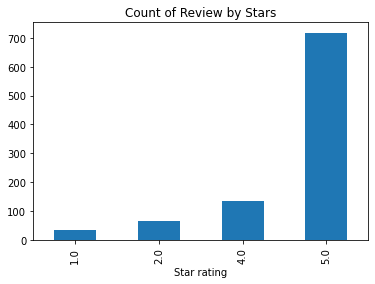

In [10]:
# visualize data distribution
ax = df['star_rating'].value_counts().sort_index().plot(kind='bar', title='Count of Review by Stars')
ax.set_xlabel('Star rating')
plt.show()

### Step 2 - run pipeline

In [7]:
def pipeline_eval(pipe, data, positive_label, negative_label):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
      text = row['review_body']
      result = pipe(text)[0]
      result['Id'] = row['Id']
      res_dict[i] = result
      if row['star_rating'] < 3.0:
        total[0] += 1
        if result['label'] == negative_label:
          correct[0] += 1
      elif row['star_rating'] > 3.0:
        total[1] += 1
        if result['label'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [7]:
!nvidia-smi

Wed Apr  3 02:31:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   34C    P0              60W / 500W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [16]:
pipe_bert = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-amazon_polarity", device=0)

In [17]:
# output example
example = df['review_body'][0]
pipe_bert(example)

[{'label': 'positive', 'score': 0.9992735981941223}]

In [18]:
# evaluate the dataset with BERT
bert_res, bert_correct, bert_total, bert_runtime = pipeline_eval(pipe_bert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [62]:
# calculate the accuracy
print(f'==> Negative Accuracy: {bert_correct[0]/bert_total[0]}')
print(f'==> Positive Accuracy: {bert_correct[1]/bert_total[1]}')
print(f'==> Total Accuracy: {np.sum(bert_correct) / np.sum(bert_total)}')
print(f'==> Total Runtime: {bert_runtime}')

==> Negative Accuracy: 0.9696969696969697
==> Positive Accuracy: 0.9260143198090692
==> Total Accuracy: 0.9306296691568837
==> Total Runtime: 12.868469476699829


#### DistilBert Pipeline

In [9]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon")

In [10]:
pipe_distilbert.model.num_parameters()

66955010

In [11]:
# output example
example = df['review_body'][787]
print(example)
pipe_distilbert(example)

It is not the most creative work but it is certainly interesting.  I think, the movie, however, was horrible.  How would anybody who didn't read the book be able to understand the movie.  No one in a million years would be able to make the connection that the black slab that appears on Earth 3 million years ago is what gave early man the idea of using bone fragments as a mean for hunting for food.  The book is definitely 10 times better than the movie.    If anybody has a comment or anything to say of interest feel free to email me at vpatel@flinet.com


[{'label': 'positive', 'score': 0.8007070422172546}]

In [12]:
# evaluate the dataset on DistilBert
distilbert_res, distilbert_correct, distilbert_total, distilbert_runtime = pipeline_eval(pipe_distilbert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [13]:
# calculate the accuracy
print(f'==> Negative Accuracy: {distilbert_correct[0]/distilbert_total[0]}')
print(f'==> Positive Accuracy: {distilbert_correct[1]/distilbert_total[1]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct) / np.sum(distilbert_total)}')
print(f'==> Total Runtime: {distilbert_runtime}')

==> Negative Accuracy: 0.9090909090909091
==> Positive Accuracy: 0.9630071599045346
==> Total Accuracy: 0.9573105656350054
==> Total Runtime: 461.0469117164612


In [14]:
f1_score_pos_1 = (2 * distilbert_correct[1]) / (2 * distilbert_correct[1] + distilbert_total[0] - distilbert_correct[0] + distilbert_total[1] - distilbert_correct[1])

print("F1 Score positive:", f1_score_pos_1)

F1 Score positive: 0.9758162031438936


In [15]:
# method 2 for F1 score
negative_accuracy = distilbert_correct[0] / distilbert_total[0]
positive_accuracy = distilbert_correct[1] / distilbert_total[1]
total_accuracy = np.sum(distilbert_correct) / np.sum(distilbert_total)

precision = distilbert_correct[1] / (distilbert_correct[1] + distilbert_total[0] - distilbert_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score pos: {f1_score}')

==> Precision: 0.9889705882352942
==> Recall: 0.9630071599045346
==> F1 Score pos: 0.9758162031438936


In [16]:
f1_score_neg = (2 * distilbert_correct[0]) / (2 * distilbert_correct[0] + distilbert_total[0] - distilbert_correct[0] + distilbert_total[1] - distilbert_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.8181818181818182


In [17]:
macro_f1 = (f1_score_pos_1 + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.8969990106628559


#### Electra Pipeline

In [17]:
pipe_electra = pipeline("text-classification", model="pig4431/amazonPolarity_ELECTRA_5E")

In [18]:
pipe_electra.model.num_parameters()

109483778

In [55]:
# output example
example = df['review_body'][93]
print(example)
pipe_electra(example)

I was checking on this book because I just recommended it as an acquisition for the library at the community colllege where I teach.  The book describes the life of a brilliant Nobel Prize-winning physicist, and shows him as a completely accessible human being.  He gives a marvelously entertaining account of some of the experiments he conducted while a college undergraduate - all of them completely understandable to a layperson.  But the book continues through his adult life: his attempts to learn Japanese, his experiences as a patron and legal defender of a local strip club, his encounters with military stuffed shirts during WWII, and dozens of other adventures.  If you want to convince yourself or someone else that it's possible to be a brilliant scientist and a real human being simultaneously, then this is the book.  Both as entertainment and as information, it's a smashing success


[{'label': 'LABEL_1', 'score': 0.9992049336433411}]

In [21]:
# evaluate the dataset on Electra
electra_res, electra_correct, electra_total, electra_runtime = pipeline_eval(pipe_electra, df, 'LABEL_1', 'LABEL_0')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [22]:
# calculate the accuracy
print(f'==> Negative Accuracy: {electra_correct[0]/electra_total[0]}')
print(f'==> Positive Accuracy: {electra_correct[1]/electra_total[1]}')
print(f'==> Total Accuracy: {np.sum(electra_correct) / np.sum(electra_total)}')
print(f'==> Total Runtime: {electra_runtime}')

==> Negative Accuracy: 0.9494949494949495
==> Positive Accuracy: 0.9582338902147971
==> Total Accuracy: 0.9573105656350054
==> Total Runtime: 909.696227312088


In [23]:
f1_score_pos = (2 * electra_correct[1]) / (2 * electra_correct[1] + electra_total[0] - electra_correct[0] + electra_total[1] - electra_correct[1])

print("F1 Score positive:", f1_score_pos)

F1 Score positive: 0.9756986634264885


In [24]:
# method 2 for F1 score
negative_accuracy = electra_correct[0] / electra_total[0]
positive_accuracy = electra_correct[1] / electra_total[1]
total_accuracy = np.sum(electra_correct) / np.sum(electra_total)

precision = electra_correct[1] / (electra_correct[1] + electra_total[0] - electra_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score: {f1_score}')

==> Precision: 0.9938118811881188
==> Recall: 0.9582338902147971
==> F1 Score: 0.9756986634264885


In [25]:
f1_score_neg = (2 * electra_correct[0]) / (2 * electra_correct[0] + electra_total[0] - electra_correct[0] + electra_total[1] - electra_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.8245614035087719


In [26]:
macro_f1 = (f1_score_pos + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.9001300334676302


> distilbert model failure cases

In [92]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and distilbert_label == "positive"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and distilbert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Grisham needs a co-author 
 The Client again demonstrates that success is built upon the abysmally low standards of the American reader and the resonance engendered in that public by detailing the slime of the American legal system. The book is a tour de force of weaving together a cast of cartoon characters, farcical plot  and a No Henry ending by means of talented prose. The guy can write but he demonstratively lacks anything to write about. Grisham's motto appears to be: Suspend any rational though when you read this book.<br /><br />His books fall into two classes: 1) Hate &quot;whitey&quot; polemics and 2) Action-Suspense without suspense but with random action.<br /> He would please me if he would join forces with another writer who had a head for story line, character development and had a logical mind. With such help, a future Grisham novel could make sense as well as have great surging prose style.

===> False Negative:
 title: An excellent treatis

> Electra model failure cases

In [33]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and electra_label == "LABEL_1"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and electra_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Clarke too old to write new words 
 <br />Have read all the books in this series, and literally got to read them again in this one. Clarke is one of the few authors in the world unafraid to plaigiarize himself.  Several of the chapters of this extremely slim volume are word-for-word lifts from the other books.<br />If your memory is bad or this is the first work of Clarke's that you've ever picked up, then you'll probably enjoy this little read, but I'd wait until it comes out in paperback if I were you

===> False Negative:
 title: Horror creeps upon you like a cold wind 
 Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling throu

## Zero-shot Sentiment Analysis with Pre-trained LLM

In [15]:
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import accelerate
import time

In [5]:
!nvidia-smi

Sun Mar 31 21:08:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:41:00.0 Off |                    0 |
| N/A   31C    P0              62W / 500W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### define LLM pipeline

In [6]:
def pipeline_eval_llm(pipe, data, template, positive_label, negative_label):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
      text = row['review_body']
      prompt = template.format(text = text)
      result = pipe(prompt)[0]
      result['Id'] = row['Id']
      res_dict[i] = result
      if row['star_rating'] < 3.0:
        total[0] += 1
        if result['generated_text'] == negative_label:
          correct[0] += 1
      elif row['star_rating'] > 3.0:
        total[1] += 1
        if result['generated_text'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [7]:
task_name = 'sentiment classification'
label_space = ['negative', 'positive']
task_definition = f'Given the sentence, assign a sentiment label from {label_space}'
output_format = "Return label only without any other text."

template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

#### Flan-T5 pipeline

In [10]:
# Flan-T5
pipeFlanT5 = pipeline("text2text-generation", model="google/flan-t5-xxl", device=0)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
pipeFlanT5.model.num_parameters()

11135332352

In [12]:
example = "Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling through a dank horror house.  What grisly find waits around the next corner?<br /><br /> You'll never solve this mystery.  It's too cunning.  But you'll relish the goosebumps that sweep over you like a cold sea-wind, and the horror that catches in your throat like poisoned wine."
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanT5(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

/home/chen.shaoy/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


input : Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling through a dank horror house.  What grisly find waits around the next corner?<br /><br /> You'll never solve this mystery.  It's too cunning.  But you'll relish the goosebumps that sweep over you like a cold sea-wind, and the horror that catches in your throat like poisoned wine.
output : [{'generated_text': 'positive'}]
runtime : 0.8942279815673828


In [13]:
# evaluate the dataset with Flan-T5
FlanT5_res, FlanT5_correct, FlanT5_total, FlanT5_runtime = pipeline_eval_llm(pipeFlanT5, df, template, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/ipykernel_l

In [14]:
# calculate the accuracy
print(f'==> Negative Accuracy: {FlanT5_correct[0]/FlanT5_total[0]}')
print(f'==> Positive Accuracy: {FlanT5_correct[1]/FlanT5_total[1]}')
print(f'==> Total Accuracy: {np.sum(FlanT5_correct) / np.sum(FlanT5_total)}')
print(f'==> Total Runtime: {FlanT5_runtime}')

==> Negative Accuracy: 0.9595959595959596
==> Positive Accuracy: 0.9660421545667447
==> Total Accuracy: 0.9653725078698846
==> Total Runtime: 252.8120458126068


In [15]:
f1_score_pos = (2 * FlanT5_correct[1]) / (2 * FlanT5_correct[1] + FlanT5_total[0] - FlanT5_correct[0] + FlanT5_total[1] - FlanT5_correct[1])

print("F1 Score positive:", f1_score_pos)

F1 Score positive: 0.9803921568627451


In [16]:
# method 2 for F1 score
negative_accuracy = FlanT5_correct[0] / FlanT5_total[0]
positive_accuracy = FlanT5_correct[1] / FlanT5_total[1]
total_accuracy = np.sum(FlanT5_correct) / np.sum(FlanT5_total)

precision = FlanT5_correct[1] / (FlanT5_correct[1] + FlanT5_total[0] - FlanT5_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score pos: {f1_score}')

==> Precision: 0.9951749095295537
==> Recall: 0.9660421545667447
==> F1 Score pos: 0.9803921568627451


In [17]:
f1_score_neg = (2 * FlanT5_correct[0]) / (2 * FlanT5_correct[0] + FlanT5_total[0] - FlanT5_correct[0] + FlanT5_total[1] - FlanT5_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.852017937219731


In [18]:
macro_f1 = (f1_score_pos + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.916205047041238


#### Flan-UL2 Pipeline

In [8]:
# flan-UL2
pipeFlanUL2 = pipeline("text2text-generation", model="google/flan-ul2", device=0)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
del pipeFlanT5

In [9]:
pipeFlanUL2.model.num_parameters()

19459613696

In [10]:
example = "Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action"
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanUL2(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

input : Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action
output : [{'generated_text': 'positive'}]
runtime : 0.5456089973449707


/home/chen.shaoy/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [11]:
# evaluate the dataset with Flan-UL2
FlanUL2_res, FlanUL2_correct, FlanUL2_total, FlanUL2_runtime = pipeline_eval_llm(pipeFlanUL2, df, template, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/ipykernel_l

In [12]:
# calculate the accuracy
print(f'==> Negative Accuracy: {FlanUL2_correct[0]/FlanUL2_total[0]}')
print(f'==> Positive Accuracy: {FlanUL2_correct[1]/FlanUL2_total[1]}')
print(f'==> Total Accuracy: {np.sum(FlanUL2_correct) / np.sum(FlanUL2_total)}')
print(f'==> Total Runtime: {FlanUL2_runtime}')

==> Negative Accuracy: 0.9595959595959596
==> Positive Accuracy: 0.9742388758782201
==> Total Accuracy: 0.9727177334732424
==> Total Runtime: 392.19344115257263


In [13]:
f1_score_pos = (2 * FlanUL2_correct[1]) / (2 * FlanUL2_correct[1] + FlanUL2_total[0] - FlanUL2_correct[0] + FlanUL2_total[1] - FlanUL2_correct[1])

print("F1 Score positive:", f1_score_pos)

F1 Score positive: 0.9846153846153847


In [14]:
# method 2 for F1 score
negative_accuracy = FlanUL2_correct[0] / FlanUL2_total[0]
positive_accuracy = FlanUL2_correct[1] / FlanUL2_total[1]
total_accuracy = np.sum(FlanUL2_correct) / np.sum(FlanUL2_total)

precision = FlanUL2_correct[1] / (FlanUL2_correct[1] + FlanUL2_total[0] - FlanUL2_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score pos: {f1_score}')

==> Precision: 0.9952153110047847
==> Recall: 0.9742388758782201
==> F1 Score pos: 0.9846153846153846


In [15]:
f1_score_neg = (2 * FlanUL2_correct[0]) / (2 * FlanUL2_correct[0] + FlanUL2_total[0] - FlanUL2_correct[0] + FlanUL2_total[1] - FlanUL2_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.8796296296296297


In [16]:
macro_f1 = (f1_score_pos + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.9321225071225072


#### results evaluation

|Model|FlanT5|FlanUL2|
|-|-|-|
|Accuracy|0.9653|**0.9727**|
|Runtime(GPU)/s|**253.22**|301.77|
|Runtime(CPU)/s|6479.03|-|

## Hybrid Method

### Experiments for the threshold

In [17]:
# Selecting columns of interest
df = df[['star_rating', 'review_headline', 'review_body']]

# Selecting the next 1000 reviews
testing_df = df.iloc[1000:2000]

print(testing_df.shape)

(1000, 3)


In [18]:
testing_df = testing_df.query('star_rating != 3.0')
testing_df = testing_df.reset_index().rename(columns = {'index': 'Id'})
testing_df.shape

(946, 4)

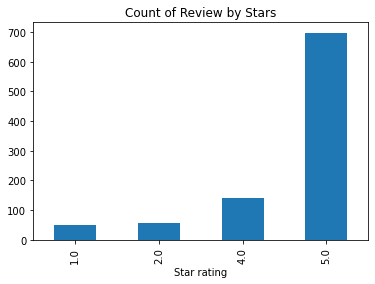

In [19]:
# visualize data distribution
ax = testing_df['star_rating'].value_counts().sort_index().plot(kind='bar', title='Count of Review by Stars')
ax.set_xlabel('Star rating')
plt.show()

In [88]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon")

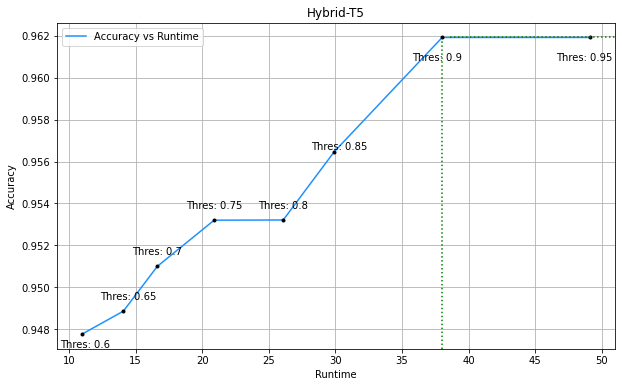

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

threshold = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
t = [10.9893, 14.0736, 16.6264, 20.8899, 26.0746, 29.9092, 38.0105, 49.07964]
accuracy = [0.94777, 0.94886, 0.9510, 0.9532, 0.95321, 0.95647, 0.96192, 0.96192]

# Find the index of the threshold 0.9
index_09 = threshold.index(0.9)
time_09 = t[index_09]
accuracy_09 = accuracy[index_09]

# Creating the spline to interpolate the points
x_smooth = np.linspace(min(t), max(t), 300)
spl = make_interp_spline(t, accuracy, k=1) 
y_smooth = spl(x_smooth)

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting the smoothed curve with a single color
plt.plot(x_smooth, y_smooth, label='Accuracy vs Runtime', color='dodgerblue')

# Adding small dots at each threshold spot
plt.plot(t, accuracy, 'o', color='black', markersize=3)

# Draw dotted lines at the selected threshold
plt.axhline(y=accuracy_09, xmin=0.705,color='g', linestyle=':' )
plt.axvline(x=time_09,ymax=0.95, color='g', linestyle=':')

# Adding threshold annotations (on original data points) with adjusted positions
for i, thr in enumerate(threshold):
    if thr in [0.6]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(3,-5), ha='center', va='top')
    elif thr in [0.65]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(5,20), ha='center', va='top')
    elif thr in [0.85]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(5,10), ha='center', va='top')
    elif thr in [0.9, 0.95]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(-5,-15), ha='center', va='top')
    else:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(0,10), ha='center', va='bottom')

# Setting the labels and title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Hybrid-T5')
plt.grid(True)

# Show plot
plt.legend()
plt.show()


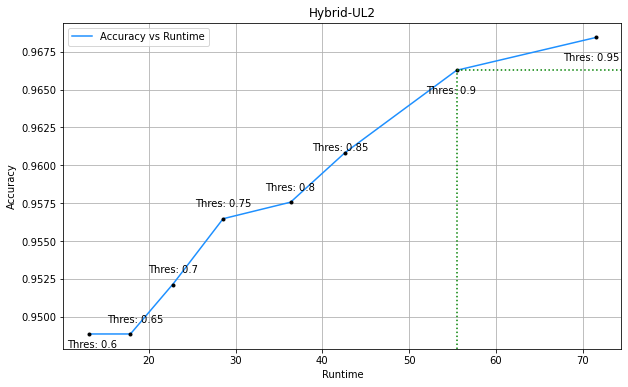

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

threshold = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
t = [13.08176, 17.8923, 22.7464, 28.55989, 36.32835, 42.59456, 55.44718, 71.50628]
accuracy = [0.94886, 0.94886, 0.95212, 0.95647, 0.95756, 0.96083, 0.96627, 0.96844]

# Find the index of the threshold 0.9
index_09 = threshold.index(0.9)
time_09 = t[index_09]
accuracy_09 = accuracy[index_09]

# Creating the spline to interpolate the points
x_smooth = np.linspace(min(t), max(t), 300)
spl = make_interp_spline(t, accuracy, k=1) 
y_smooth = spl(x_smooth)

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting the smoothed curve with a single color
plt.plot(x_smooth, y_smooth, label='Accuracy vs Runtime', color='dodgerblue')

# Adding small dots at each threshold spot
plt.plot(t, accuracy, 'o', color='black', markersize=3)

# Draw dotted lines at the selected threshold
plt.axhline(y=accuracy_09, xmin=0.705,color='g', linestyle=':' )
plt.axvline(x=time_09,ymax=0.85, color='g', linestyle=':')

# Adding threshold annotations (on original data points) with adjusted positions
for i, thr in enumerate(threshold):
    if thr in [0.6]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(3,-5), ha='center', va='top')
    elif thr in [0.65]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(5,20), ha='center', va='top')
    elif thr in [0.85]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(-5,10), ha='center', va='top')
    elif thr in [0.9, 0.95]:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(-5,-15), ha='center', va='top')
    else:
        plt.annotate(f'Thres: {thr}', (t[i], accuracy[i]), textcoords="offset points", xytext=(0,10), ha='center', va='bottom')

# Setting the labels and title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Hybrid-UL2')
plt.grid(True)

# Show plot
plt.legend()
plt.show()


### hybrid pipeline

In [20]:
def hybrid_pipeline(pipe_slm, pipe_llm, data, slm_threshold, template, positive_label, negative_label):
    res_dict = {}
    correct = [0 for _ in range(2)]
    total = [0 for _ in range(2)]

    start_time = time.time()
    for i, row in tqdm(data.iterrows(), total=len(data)):
        try:
            text = row['review_body']
            # use SLMs pipeline
            slm_result = pipe_slm(text)[0]
            slm_confidence = slm_result['score']
            if slm_confidence >= slm_threshold:
                result = slm_result
            else:
                # change to LLMs pipeline
                prompt = template.format(text=text)
                llm_result = pipe_llm(prompt)[0]
                result = {'label': llm_result['generated_text'], 'confidence': slm_confidence}
            result['Id'] = row['Id']
            res_dict[i] = result
            if row['star_rating'] < 3.0:
                total[0] += 1
                if result['label'] == negative_label:
                    correct[0] += 1
            elif row['star_rating'] > 3.0:
                total[1] += 1
                if result['label'] == positive_label:
                    correct[1] += 1
        except RuntimeError:
            print(f'{i}th row broke. The input text is too long.')
            print(IndexError)
        except IndexError:
            print(f'{i}th row broke. The input text is too long.')
            print(IndexError)
    end_time = time.time()
    runtime = end_time - start_time
    return res_dict, correct, total, runtime


### Hybrid1 - distilBert and pipeFlanT5

In [95]:
# Define threshold for SLMs confidence
slm_threshold = 0.90

# Define task details for LLMs
task_name = 'sentiment classification'
label_space = ['negative', 'positive']
task_definition = f'Given the sentence, assign a sentiment label from {label_space}'
output_format = "Return label only without any other text."
template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

# Load SLMs pipeline
pipe_distilBert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon", device=0)

# Load LLMs pipeline
pipeFlanT5 = pipeline("text2text-generation", model="google/flan-t5-xxl", device=0)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [94]:
import gc
del pipeFlanT5
gc.collect()
torch.cuda.empty_cache()

In [96]:
hybrid1_res, hybrid1_correct, hybrid1_total, hybrid1_runtime = hybrid_pipeline(pipe_distilBert, pipeFlanT5, testing_df, slm_threshold, template, 'positive', 'negative')
# print("Results:", hybrid1_res)
# print("Correct:", hybrid1_correct)
# print("Total:", hybrid1_total)

  0%|          | 0/946 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


7th row broke. The input text is too long.
<class 'IndexError'>
15th row broke. The input text is too long.
<class 'IndexError'>
16th row broke. The input text is too long.
<class 'IndexError'>
27th row broke. The input text is too long.
<class 'IndexError'>
35th row broke. The input text is too long.
<class 'IndexError'>


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


162th row broke. The input text is too long.
<class 'IndexError'>
280th row broke. The input text is too long.
<class 'IndexError'>
313th row broke. The input text is too long.
<class 'IndexError'>
385th row broke. The input text is too long.
<class 'IndexError'>
413th row broke. The input text is too long.
<class 'IndexError'>
461th row broke. The input text is too long.
<class 'IndexError'>
507th row broke. The input text is too long.
<class 'IndexError'>
536th row broke. The input text is too long.
<class 'IndexError'>
542th row broke. The input text is too long.
<class 'IndexError'>
580th row broke. The input text is too long.
<class 'IndexError'>
604th row broke. The input text is too long.
<class 'IndexError'>
605th row broke. The input text is too long.
<class 'IndexError'>
625th row broke. The input text is too long.
<class 'IndexError'>
635th row broke. The input text is too long.
<class 'IndexError'>
639th row broke. The input text is too long.
<class 'IndexError'>
673th row 

In [97]:
# calculate the accuracy
print(f'==> Negative Accuracy: {hybrid1_correct[0]/hybrid1_total[0]}')
print(f'==> Positive Accuracy: {hybrid1_correct[1]/hybrid1_total[1]}')
print(f'==> Total Accuracy: {np.sum(hybrid1_correct) / np.sum(hybrid1_total)}')
print(f'==> Total Runtime: {hybrid1_runtime}')

==> Negative Accuracy: 0.9809523809523809
==> Positive Accuracy: 0.9594594594594594
==> Total Accuracy: 0.9619151251360174
==> Total Runtime: 38.66688656806946


In [98]:
f1_score_pos = (2 * hybrid1_correct[1]) / (2 * hybrid1_correct[1] + hybrid1_total[0] - hybrid1_correct[0] + hybrid1_total[1] - hybrid1_correct[1])

print("F1 Score positive:", f1_score_pos)

F1 Score positive: 0.9780839073262367


In [99]:
# method 2 for F1 score
negative_accuracy = hybrid1_correct[0] / hybrid1_total[0]
positive_accuracy = hybrid1_correct[1] / hybrid1_total[1]
total_accuracy = np.sum(hybrid1_correct) / np.sum(hybrid1_total)

precision = hybrid1_correct[1] / (hybrid1_correct[1] + hybrid1_total[0] - hybrid1_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score pos: {f1_score}')

==> Precision: 0.9974457215836526
==> Recall: 0.9594594594594594
==> F1 Score pos: 0.9780839073262367


In [100]:
f1_score_neg = (2 * hybrid1_correct[0]) / (2 * hybrid1_correct[0] + hybrid1_total[0] - hybrid1_correct[0] + hybrid1_total[1] - hybrid1_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.8547717842323651


In [101]:
macro_f1 = (f1_score_pos + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.9164278457793009


In [102]:
# method2 to calculate macro F1
# Calculate TP, FP, FN
tp_positive = hybrid1_correct[1]
tp_negative = hybrid1_correct[0]

fp_positive = hybrid1_total[1] - tp_positive
fp_negative = hybrid1_total[0] - tp_negative

fn_positive = fp_negative
fn_negative = fp_positive

# Calculate F1 Score for Positive and Negative classes
f1_positive = 2 * tp_positive / (2 * tp_positive + fp_positive + fn_positive)
f1_negative = 2 * tp_negative / (2 * tp_negative + fp_negative + fn_negative)

# Calculate weighted average of F1 scores (assuming equal weight for positive and negative classes)
f1_score = (f1_positive + f1_negative) / 2

print("F1 Score:", f1_score)


F1 Score: 0.9164278457793009


### Hybrid2 - distilBert and pipeFlanUL2

In [173]:
# Hybrid1 - distilBert and pipeFlanUL2
# Define threshold for SLMs confidence
slm_threshold = 0.95

# Define task details for LLMs
task_name = 'sentiment classification'
label_space = ['negative', 'positive']
task_definition = f'Given the sentence, assign a sentiment label from {label_space}'
output_format = "Return label only without any other text."
template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

# Load SLMs pipeline
pipe_distilBert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon", device=0)

# Load LLMs pipeline
pipeFlanUL2 = pipeline("text2text-generation", model="google/flan-ul2",device=0)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [172]:
import gc
del pipeFlanUL2
gc.collect()
torch.cuda.empty_cache()

In [174]:
hybrid2_res, hybrid2_correct, hybrid2_total, hybrid2_runtime = hybrid_pipeline(pipe_distilBert, pipeFlanUL2, testing_df, slm_threshold, template, 'positive', 'negative')
# print("Results:", hybrid1_res)
# print("Correct:", hybrid1_correct)
# print("Total:", hybrid1_total)


  0%|          | 0/946 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


7th row broke. The input text is too long.
<class 'IndexError'>
15th row broke. The input text is too long.
<class 'IndexError'>
16th row broke. The input text is too long.
<class 'IndexError'>
27th row broke. The input text is too long.
<class 'IndexError'>
35th row broke. The input text is too long.
<class 'IndexError'>
162th row broke. The input text is too long.
<class 'IndexError'>
280th row broke. The input text is too long.
<class 'IndexError'>
313th row broke. The input text is too long.
<class 'IndexError'>
385th row broke. The input text is too long.
<class 'IndexError'>
413th row broke. The input text is too long.
<class 'IndexError'>
461th row broke. The input text is too long.
<class 'IndexError'>
507th row broke. The input text is too long.
<class 'IndexError'>
536th row broke. The input text is too long.
<class 'IndexError'>
542th row broke. The input text is too long.
<class 'IndexError'>
580th row broke. The input text is too long.
<class 'IndexError'>
604th row broke.

In [175]:
# calculate the accuracy
print(f'==> Negative Accuracy: {hybrid2_correct[0]/hybrid2_total[0]}')
print(f'==> Positive Accuracy: {hybrid2_correct[1]/hybrid2_total[1]}')
print(f'==> Total Accuracy: {np.sum(hybrid2_correct) / np.sum(hybrid2_total)}')
print(f'==> Total Runtime: {hybrid2_runtime}')

==> Negative Accuracy: 0.9714285714285714
==> Positive Accuracy: 0.9680589680589681
==> Total Accuracy: 0.9684439608269858
==> Total Runtime: 71.50627660751343


In [176]:
# method 2 for F1 score
negative_accuracy = hybrid2_correct[0] / hybrid2_total[0]
positive_accuracy = hybrid2_correct[1] / hybrid2_total[1]
total_accuracy = np.sum(hybrid2_correct) / np.sum(hybrid2_total)

precision = hybrid2_correct[1] / (hybrid2_correct[1] + hybrid2_total[0] - hybrid2_correct[0])
recall = positive_accuracy

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'==> Precision: {precision}')
print(f'==> Recall: {recall}')
print(f'==> F1 Score pos: {f1_score}')

==> Precision: 0.9962073324905183
==> Recall: 0.9680589680589681
==> F1 Score pos: 0.9819314641744548


In [177]:
f1_score_pos = (2 * hybrid2_correct[1]) / (2 * hybrid2_correct[1] + hybrid2_total[0] - hybrid2_correct[0] + hybrid2_total[1] - hybrid2_correct[1])

print("F1 Score positive:", f1_score_pos)

F1 Score positive: 0.9819314641744549


In [178]:
f1_score_neg = (2 * hybrid2_correct[0]) / (2 * hybrid2_correct[0] + hybrid2_total[0] - hybrid2_correct[0] + hybrid2_total[1] - hybrid2_correct[1])

print("F1 Score negative:", f1_score_neg)

F1 Score negative: 0.8755364806866953


In [179]:
macro_f1 = (f1_score_pos + f1_score_neg)/2
print("F1 Score Macro:", macro_f1)

F1 Score Macro: 0.9287339724305751


In [180]:
# method2 to calculate macro F1
# Calculate TP, FP, FN
tp_positive = hybrid2_correct[1]
tp_negative = hybrid2_correct[0]

fp_positive = hybrid2_total[1] - tp_positive
fp_negative = hybrid2_total[0] - tp_negative

fn_positive = fp_negative
fn_negative = fp_positive

# Calculate F1 Score for Positive and Negative classes
f1_positive = 2 * tp_positive / (2 * tp_positive + fp_positive + fn_positive)
f1_negative = 2 * tp_negative / (2 * tp_negative + fp_negative + fn_negative)

# Calculate weighted average of F1 scores (assuming equal weight for positive and negative classes)
f1_score = (f1_positive + f1_negative) / 2

print("F1 Score:", f1_score)


F1 Score: 0.9287339724305751
